In [1]:
# pip install --user sklearn

In [23]:
!nvidia-smi

Mon Jun 28 04:20:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.84       Driver Version: 460.84       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     On   | 00000000:1A:00.0 Off |                  Off |
| 35%   33C    P8    31W / 260W |  24115MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 6000     On   | 00000000:1C:00.0 Off |                  Off |
| 33%   

In [27]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os as os
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.layers import GlobalMaxPooling2D,Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split

In [28]:
seed = 2021
os.environ['PYTHONHASHSEED']=str(seed)
python_random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

In [29]:
# get training dataset 
train = pd.read_csv('data/correa/train_censored.csv')

img_paths = train['hiti_path']
new_paths = []
for i in range(len(img_paths)):
    path = img_paths[i] 
    new_path = "/home/jupyter-pochi/" + path[1:]
    # new_path = path.replace('/home/jupyter-correa/JACR_Sep_Dec_2019//','/home/jupyter-chima/data/Emory_CXR_Project/JACR_Sep_Dec_2019/')
    new_paths.append(new_path)

train['Path'] = new_paths 
train = train[['Path','Race']] 
train

,Path,Race
0,/home/jupyter-pochi/data/Emory_CXR_Project/JAC...,HISPANIC/LATINO
1,/home/jupyter-pochi/data/correa/JACR_Sep_Dec_2...,WHITE
2,/home/jupyter-pochi/data/Emory_CXR_Project/JAC...,WHITE
3,/home/jupyter-pochi/data/Emory_CXR_Project/JAC...,BLACK/AFRICAN AMERICAN
4,/home/jupyter-pochi/data/Emory_CXR_Project/JAC...,WHITE
...,...,...
199024,/home/jupyter-pochi/data/correa/JACR_Sep_Dec_2...,WHITE
199025,/home/jupyter-pochi/data/correa/JACR_Sep_Dec_2...,WHITE
199026,/home/jupyter-pochi/data/correa/JACR_Sep_Dec_2...,WHITE
199027,/home/jupyter-pochi/data/correa/JACR_Sep_Dec_2...,WHITE


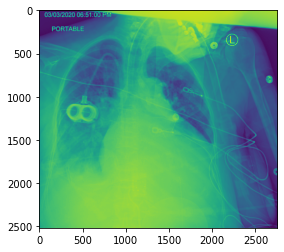

In [30]:
# load sample images from training dataset
img_paths = train['Path']
sample_path = img_paths[100]

img = mpimg.imread(sample_path)
imgplot = plt.imshow(img)
plt.show()

In [31]:
train.Race.value_counts() 

WHITE                     91369
BLACK/AFRICAN AMERICAN    87139
OTHER                      9876
ASIAN                      6457
HISPANIC/LATINO            3693
NATIVE                      495
Name: Race, dtype: int64

In [32]:
train.drop(train.loc[train['Race'] == 'Not Recorded'].index, inplace=True) # ignore not recorded case
train.drop(train.loc[train['Race'] == 'HISPANIC/LATINO'].index, inplace=True) # ignore not recorded case
train.drop(train.loc[train['Race'] == 'NATIVE'].index, inplace=True) # ignore not recorded case
train.drop(train.loc[train['Race'] == 'OTHER'].index, inplace=True) # ignore not recorded case


# train['Race'] = train['Race'].replace('ASIAN','OTHER') # merge asian, hispanic and native
# train['Race'] = train['Race'].replace('HISPANIC/LATINO','OTHER')
# train['Race'] = train['Race'].replace('NATIVE','OTHER')

In [33]:
train.Race.value_counts() 

WHITE                     91369
BLACK/AFRICAN AMERICAN    87139
ASIAN                      6457
Name: Race, dtype: int64

In [34]:
# get validation dataset 
valid = pd.read_csv('data/correa/val_censored.csv')

img_paths = valid['hiti_path']
new_paths = []
for i in range(len(img_paths)):
    path = img_paths[i] 
    new_path = "/home/jupyter-pochi/" + path[1:]
    # new_path = path.replace('/home/jupyter-correa/JACR_Sep_Dec_2019//','/home/jupyter-chima/data/Emory_CXR_Project/JACR_Sep_Dec_2019/')
    new_paths.append(new_path)

valid['Path'] = new_paths 
valid = valid[['Path','Race']] 
valid

,Path,Race
0,/home/jupyter-pochi/data/correa/JACR_may_aug_2...,WHITE
1,/home/jupyter-pochi/data/correa/JACR_may_aug_2...,BLACK/AFRICAN AMERICAN
2,/home/jupyter-pochi/data/correa/JACR_may_aug_2...,WHITE
3,/home/jupyter-pochi/data/correa/JACR_may_aug_2...,BLACK/AFRICAN AMERICAN
4,/home/jupyter-pochi/data/correa/JACR_Sep_Dec_2...,BLACK/AFRICAN AMERICAN
...,...,...
15979,/home/jupyter-pochi/data/correa/JACR_may_aug_2...,WHITE
15980,/home/jupyter-pochi/data/Emory_CXR_Project/JAC...,WHITE
15981,/home/jupyter-pochi/data/correa/JACR_may_aug_2...,WHITE
15982,/home/jupyter-pochi/data/Emory_CXR_Project/JAC...,BLACK/AFRICAN AMERICAN


In [35]:
img_paths

0        /data/correa/JACR_may_aug_2019_v2/JACR_may_aug...
1        /data/correa/JACR_may_aug_2019_v2/JACR_may_aug...
2        /data/correa/JACR_may_aug_2019_v2/JACR_may_aug...
3        /data/correa/JACR_may_aug_2019_v2/JACR_may_aug...
4        /data/correa/JACR_Sep_Dec_2019_v2/extracted-im...
                               ...                        
15979    /data/correa/JACR_may_aug_2019_v2/JACR_may_aug...
15980    /data/Emory_CXR_Project/JACR_May_Aug_2020/extr...
15981    /data/correa/JACR_may_aug_2019_v2/JACR_may_aug...
15982    /data/Emory_CXR_Project/JACR_May_Aug_2020/extr...
15983    /data/correa/JACR_jan_april_2019_v2/JACR_Jan_A...
Name: hiti_path, Length: 15984, dtype: object

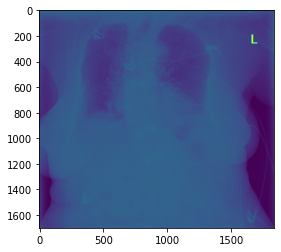

In [36]:
# load sample images from validation dataset
img_paths = valid['Path']
path = img_paths[15983]
img = mpimg.imread(path)
imgplot = plt.imshow(img)
plt.show()

In [37]:
valid.Race.value_counts()

BLACK/AFRICAN AMERICAN    7540
WHITE                     6656
OTHER                      908
ASIAN                      530
HISPANIC/LATINO            278
NATIVE                      72
Name: Race, dtype: int64

In [38]:
valid = valid.loc[valid['Race'] != 'Not Recorded'] # ignore not recorded case
valid = valid.loc[valid['Race'] != 'HISPANIC/LATINO'] # ignore not recorded case
valid = valid.loc[valid['Race'] != 'NATIVE'] # ignore not recorded case
valid = valid.loc[valid['Race'] != 'OTHER'] # ignore not recorded case




# valid['Race'] = valid['Race'].replace('ASIAN','OTHER') # merge asian, hispanic and native
# valid['Race'] = valid['Race'].replace('HISPANIC/LATINO','OTHER')
# valid['Race'] = valid['Race'].replace('NATIVE','OTHER')

In [39]:
valid.Race.value_counts()

BLACK/AFRICAN AMERICAN    7540
WHITE                     6656
ASIAN                      530
Name: Race, dtype: int64

In [40]:
# get testing dataset 
test = pd.read_csv('data/correa/test_censored.csv')

img_paths = test['hiti_path']
new_paths = []
for i in range(len(img_paths)):
    path = img_paths[i] 
    new_path = "/home/jupyter-pochi/" + path[1:]
    # new_path = path.replace('/home/jupyter-correa/JACR_Sep_Dec_2019//','/home/jupyter-chima/data/Emory_CXR_Project/JACR_Sep_Dec_2019/')
    new_paths.append(new_path)

test['Path'] = new_paths 
test = test[['Path','Race']] 
test

,Path,Race
0,/home/jupyter-pochi/data/Emory_CXR_Project/JAC...,WHITE
1,/home/jupyter-pochi/data/Emory_CXR_Project/JAC...,BLACK/AFRICAN AMERICAN
2,/home/jupyter-pochi/data/Emory_CXR_Project/JAC...,BLACK/AFRICAN AMERICAN
3,/home/jupyter-pochi/data/correa/JACR_may_aug_2...,BLACK/AFRICAN AMERICAN
4,/home/jupyter-pochi/data/correa/JACR_Sep_Dec_2...,BLACK/AFRICAN AMERICAN
...,...,...
12867,/home/jupyter-pochi/data/Emory_CXR_Project/JAC...,BLACK/AFRICAN AMERICAN
12868,/home/jupyter-pochi/data/Emory_CXR_Project/JAC...,ASIAN
12869,/home/jupyter-pochi/data/correa/JACR_may_aug_2...,OTHER
12870,/home/jupyter-pochi/data/Emory_CXR_Project/JAC...,BLACK/AFRICAN AMERICAN


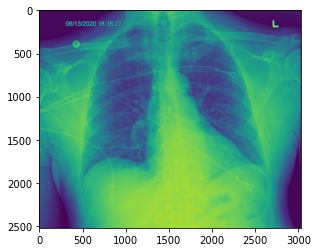

In [41]:
# load sample images from testing dataset
img_paths = test['Path']
path = img_paths[1]
img = mpimg.imread(path)
imgplot = plt.imshow(img)
plt.show()

In [42]:
test.Race.value_counts() # no multiple races

BLACK/AFRICAN AMERICAN    6067
WHITE                     5281
OTHER                      765
ASIAN                      484
HISPANIC/LATINO            225
NATIVE                      50
Name: Race, dtype: int64

In [43]:
test = test.loc[test['Race'] != 'Not Recorded'] # ignore not recorded case
test = test.loc[test['Race'] != 'HISPANIC/LATINO'] # ignore not recorded case
test = test.loc[test['Race'] != 'NATIVE'] # ignore not recorded case
test = test.loc[test['Race'] != 'OTHER'] # ignore not recorded case

# test['Race'] = test['Race'].replace('ASIAN','OTHER') # merge asian, hispanic and native
# test['Race'] = test['Race'].replace('HISPANIC/LATINO','OTHER')
# test['Race'] = test['Race'].replace('NATIVE','OTHER')

In [44]:
test.Race.value_counts() # no multiple races

BLACK/AFRICAN AMERICAN    6067
WHITE                     5281
ASIAN                      484
Name: Race, dtype: int64

In [45]:
# fix error with truncated image files
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [46]:
#central crop on 224 x 224
IMAGE_WIDTH, IMAGE_HEIGHT = (224, 224)
# IMAGE_WIDTH, IMAGE_HEIGHT = (256, 256)
EPOCHS = 10
BATCH_SIZE = 128
learning_rate = 1e-3
# decay_val= 0.0 
# image_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

In [47]:
# setup train, valid, and test image data generators
train_datagen = ImageDataGenerator(
#         rotation_range=15,
#         fill_mode='constant',
#         zoom_range=0.1,
#         horizontal_flip=True   
)
valid_datagen = ImageDataGenerator()

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train, 
    directory=None,
    x_col="Path", 
    y_col="Race", 
    class_mode="categorical", 
    color_mode='grayscale',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
    batch_size=BATCH_SIZE,
    rescale=1/255,
)

valid_generator=valid_datagen.flow_from_dataframe(
    dataframe=valid, 
    directory=None, 
    x_col="Path", 
    y_col="Race", 
    class_mode="categorical", 
    color_mode='grayscale',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
    shuffle = True, 
    batch_size=BATCH_SIZE,
    rescale=1/255,
)
test_generator=valid_datagen.flow_from_dataframe(
    dataframe=test, 
    directory=None, 
    x_col="Path", 
    y_col="Race", 
    class_mode="categorical", 
    color_mode='grayscale',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
    shuffle = False, 
    batch_size=BATCH_SIZE,
    rescale=1/255,
)

Found 184965 validated image filenames belonging to 3 classes.
Found 14726 validated image filenames belonging to 3 classes.
Found 11832 validated image filenames belonging to 3 classes.


In [48]:
# see the class names
class_names = train.Race.value_counts().index.tolist()
class_names.sort()
class_names

['ASIAN', 'BLACK/AFRICAN AMERICAN', 'WHITE']

In [49]:
#Densenet

n_labels = len(class_names)

from tensorflow.keras import backend as K

def swish_activation(x):
    return (K.sigmoid(x) * x)

INPUT_HWC = (224, 224, 1)

base_model = tf.keras.applications.densenet.DenseNet121(
        include_top=False, weights=None, input_shape=INPUT_HWC, pooling='max')

x = tf.keras.layers.Dropout(0.5)(base_model.output)
x = tf.keras.layers.Dense(256, activation=swish_activation)(x)
x = tf.keras.layers.Dense(64, activation=swish_activation)(x)
x = tf.keras.layers.Dense(16, activation=swish_activation)(x)
pred_layer = tf.keras.layers.Dense(n_labels, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=pred_layer)  

print(model.summary())


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 3136        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [50]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

In [ ]:
history = model.fit(train_generator, epochs=EPOCHS, validation_data=valid_generator, shuffle=True)

Epoch 1/10
 154/1446 [==>...........................] - ETA: 6:47:39 - loss: 0.8670

In [ ]:
model.save('/home/jupyter-pochi/Emory_DNet_2021.h5') 

In [ ]:
print(history.history.keys())

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
    
# summarize history for ROC auc
plt.plot(history.history['ROC-AUC'])
plt.plot(history.history['val_ROC-AUC'])
plt.title('ROC model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

# summarize history for ROC auc
plt.plot(history.history['PR-AUC'])
plt.plot(history.history['val_PR-AUC'])
plt.title('PR model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

In [35]:
from tensorflow.keras.models import load_model
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.layers import Activation

def swish_activation(x):
        return (K.sigmoid(x) * x)

get_custom_objects().update({'swish_activation': Activation(swish_activation)})

In [36]:
model = load_model('/home/jupyter-pochi/Emory_DNet.h5')

In [ ]:
Y_pred = model.predict(test_generator, len(test_generator.filenames)) 

In [ ]:
predictions = np.argmax(Y_pred, axis=1)
predictions = list(predictions)

In [ ]:
test_generator.class_indices

In [ ]:
# building the confusion matrix

from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, predictions))
print('Classification Report')
# batches are made in alphabetical order if shuffle is false
print(classification_report(test_generator.classes, predictions, target_names=class_names,  zero_division = 0)) 

In [ ]:
# convert the list to one hot encoded arrays
def one_hot(values_as_list):
    n_values = np.max(values_as_list) + 1
    return np.eye(n_values)[values_as_list]
    
actual = one_hot(test_generator.classes)

In [ ]:
# compute ROC curve and ROC area for each class

from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(actual[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# plot of a ROC curve for a specific class
for i in range(len(class_names)):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for ' + class_names[i])
    plt.legend(loc="lower right")
    plt.show()